### Parte 2: Creación del input


Las variables con las que se trabajará provienen del trabajo [Downscaling of surface wind forecasts using convolutional neural networks](https://npg.copernicus.org/articles/30/553/2023/npg-30-553-2023.html). En este trabajo se proponen un conjunto de 35 variables detalladas en la siguiente tabla en donde se incluyen variables asociadas directamente al viento, variables meteorológicas complementarias, variables topográficas y la gran novedad: variables que describen la interacción del viento con la topografía.

<div style="text-align: center;">
    <img src="extra/img/tablas_variables.png" alt="Variables propuestas por Dupuy (2023)" style="width: 600px;">
    <p>Figura 1: Variables propuestas por Dupuy (2023)</p>
</div>

Debido a que trabajar con todas estas variables puede conllevar a trabajar con información redudante y/o no significativa, nuestra propuesta inicial es preparar  un puñado pequeño de variables que tengan una estricta relación con el viento superficial y a partir de ahí, ir integrando nueva información para poder identificar su impacto en el rendimiento de nuestros modelos. Las propuestas son las siguientes: 

<center>

| Propuesta | Variables | 
| -------   | --------  |
| 1         | U10, V10, TH2, PBLH, HGT, XLAND | 
| 2         | + T2, PSFC | 
| 3         | + Slope, Aspect | 
| 4         | + Exposure $E_{+}$, Sheltering  $E_{-}$

</center>

A continuación se muestra una breve descripción de cada variable: 

<center>

| Variables | Descripción | Unidad |
| -------   | --------  | -----  |
| U10       | X-viento a 10 metros| $ms^{-1}$ |
| V10       | Y-viento a 10 metros| $ms^{-1}$ |
| TH2       | Temperatura potencial a 2m | K | 
| PBLH | PBL height  | m | 
| HGT | Terrain Height | m |
| XLAND | Land mask  | (1 for land, 2 for water)  |
| Slope | Pendiente con sus vecinos | degree | 
|  Aspect |  Dirección hacia donde la pendiente es más negativa | - |
| $E_{+}$ y $E_{-}$ | Refleja lugares expuestos al viento (exposure) o protegidos de él (sheltering) | - |

</center>


Información adicional: 
- PBLH: Planetary Boundary Layer Height se define generalmente como la altitud de una capa de transición donde el gradiente de temperatura o humedad del aire es significativo dentro de los primeros 1-5 kilómetros por encima de la superficie.

- $E_{+}$ y $E_{-}$: Se calculan como el seno del ángulo vertical $\alpha$ que el vector del viento tendría que cambiar para ser paralelo a la pendiente (slope) manteniendo su azimut. Este ángulo se calcula simplemente a partir del ángulo de la pendiente y de $\delta$, el ángulo entre la dirección del viento y la orientación (aspect) [(WindTopo, 2022)](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.4265)

#### 2.2. Construcción de los tensores: 

El objetivo ahora es construir los tensores de dimensiones: (n parches, 32, 32, m vars). Para ello, partimos trabajando con los archivos de la carpeta ```salidas_parche_32_32_bicubic``` que contiene los datos (cortados e interpolados) que queremos aumentar su resolución y los datos objetivos.

Lo primero será  crear una variable que contenga los parches asociados a cada caso y para cada variable. La estructura de la variable que contendrá toda la información será un diccionario anidado cuya key principal será la variable meteorológica respectiva y su diccionario interno contendrá dicha información para cada uno de los caso. Por ejemplo:

```

stack= { "U10" : { "caso_1" : valores, "caso_2", valores, ... , "caso_n": valores} },
          "HGT"        : { "caso_1" : valores, "caso_2: valores, ..., "caso_n": valores}
          ... , 
       {  "XLAND", {...}}

```



In [1]:
import tensorflow as tf 
import numpy as np 
import os 
import re

var_names = ["U10", "V10", "TH2", "PBLH", "HGT", "XLAND", "T2", "PSFC", "times"]
path= "../salidas_parche_32_32_bicubic/"

fechas_tr=["2016_12_13", "2020_05_05", "2020_01_16", "2017_07_28", 
           "2021_05_19", "2018_07_04", "2018_03_21", "2016_06_15",
           "2016_04_30", "2018_06_09", "2022_12_12", "2021_03_06",
           "2020_01_31", "2018_06_27", "2022_02_28", "2018_06_23"] 

c:\Users\ruben\anaconda3\envs\sivar\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Para una mejor comprensión de los detalles del código a continuación, tengamos en cuenta lo siguiente: 
- Cada caso contiene los archivos asociados a los dominios d03 y d05 en la misma carpeta. Por lo mismo, la importación de los archivos .npy se harán en una misma variable. Sin embargo, los primeros 120 archivos estarán asociados al dominio d03 y los siguientes al dominio d05.
- Cada carpeta contendrá 240 o 242 archivos dependiendo de si se simuló la hora 00:00 del quinto día simulado. Para tener una misma cantidad de archivos en todas las carpetas, se eliminaron los últimos archivos d03 y d05 de cada caso que contenga 242 simulaciones.
- Debido a la posible inestabilidad de WRF en las primeras horas de simulación, se tomó la decisión de eliminar las primeras 5 horas de cada fecha, lo que nos da un total de 115 archivos por dominio. 
- Para asegurarnos que hicimos la eliminación de archivos correctamente, se implementó un doble check muy casero (para cada caso y cada variable meteorológica) que compara la hora simulada del primer y último archivo d03 con la de los archivos d05. Para mayor detalle, la hora corresponde al número que sigue después de la fecha en el nombre de archivo, como ejemplo, se tiene que el archivo de nombre ``` 'wrfout_d03_2018-06-23_05%3A00%3A00.npy' ``` tiene como hora las 05 (va del 00 al 23)



In [2]:
%%time

stack= {key: '' for key in var_names} #dic. con toda la información

for var in var_names:
    stack_casos= {key: '' for key in fechas_tr} #dic con la informacion de cada caso
    for caso in fechas_tr: 

        parches_npy=[] 

        rutas_npys = path + var + "/" + caso
        archivos= os.listdir(rutas_npys) #lista con todos los archivos .npy 
        archivos_npy = [archivo for archivo in archivos if archivo.endswith('.npy')] #filtrado de archivos .npy

        #Eliminación de las 00:00 para el posible 5to día simulado
        if len(archivos_npy)== 242: #si tenemos más de 240 simulaciones 
                archivos_npy.pop(-1)  #eliminamos la última d05
                archivos_npy.pop(120) #y la última d03 

        #Eliminamos las primeras 5 simulaciones para ambos dominios
        del archivos_npy[120:125]
        archivos_npy=archivos_npy[5:]

        #Doble Check 
        patron     = re.compile(r'(\d{2})%')

        primer_d03 = archivos_npy[0]
        ultimo_d03 = archivos_npy[114]
        primer_d05 = archivos_npy[114+1]
        ultimo_d05 = archivos_npy[-1]

        patron_d03_01  = patron.search(primer_d03).group(1)
        patron_d05_01  = patron.search(primer_d05).group(1)
        patron_d03_115 = patron.search(ultimo_d03).group(1)
        patron_d05_115 = patron.search(ultimo_d05).group(1)

        if not patron_d03_01 == patron_d05_01 and patron_d03_115 == patron_d05_115:
            print("Función interrumpida")
            break 

        #importación archivos .npy
        for npy in archivos_npy: 
            ruta        =os.path.join(rutas_npys, npy)
            parches_156 = np.load(ruta)
            parches_npy.append(parches_156)

        if var != 'times': #la variable times requiere un tratamiento especial al ser una ctte.
            stack_casos[caso] = tf.squeeze(tf.convert_to_tensor(parches_npy))
        else:
            stack_casos[caso] = parches_npy

    print(f"variable {var} lista")

    stack[var] = stack_casos #guardamos el dic con los casos en su respectiva key   


variable U10 lista
variable V10 lista
variable TH2 lista
variable PBLH lista
variable HGT lista
variable XLAND lista
variable T2 lista
variable PSFC lista
variable times lista
CPU times: total: 4min 37s
Wall time: 7min 20s


In [3]:
print(f"Para {var_names[0]}")
for caso in fechas_tr:
        print(f"Dimensiones caso {caso}: ", stack[var_names[0]][caso].shape)

Para U10
Dimensiones caso 2016_12_13:  (230, 156, 32, 32)
Dimensiones caso 2020_05_05:  (230, 156, 32, 32)
Dimensiones caso 2020_01_16:  (230, 156, 32, 32)
Dimensiones caso 2017_07_28:  (230, 156, 32, 32)
Dimensiones caso 2021_05_19:  (230, 156, 32, 32)
Dimensiones caso 2018_07_04:  (230, 156, 32, 32)
Dimensiones caso 2018_03_21:  (230, 156, 32, 32)
Dimensiones caso 2016_06_15:  (230, 156, 32, 32)
Dimensiones caso 2016_04_30:  (230, 156, 32, 32)
Dimensiones caso 2018_06_09:  (230, 156, 32, 32)
Dimensiones caso 2022_12_12:  (230, 156, 32, 32)
Dimensiones caso 2021_03_06:  (230, 156, 32, 32)
Dimensiones caso 2020_01_31:  (230, 156, 32, 32)
Dimensiones caso 2018_06_27:  (230, 156, 32, 32)
Dimensiones caso 2022_02_28:  (230, 156, 32, 32)
Dimensiones caso 2018_06_23:  (230, 156, 32, 32)


Al completar el proceso de importación de los archivos npy, se observó que cada variable meteorológica dentro de nuestro ```stack``` contiene un array de dimnesiones $(230, 156, 32, 32)$. La primera dimensión se refiere a los 230 archivos (115 d03 y 115 d05) importados, la segunda hace referencia a los 156 parches por cada archivo, y las últimas dos a las dimensiones de los parches. Si hacemos los cálculos, tenemos la siguiente cantidad de parches por variable: 

<center>

| Conjunto | Cantidad de parches | 
|  ------  |  ------------------ | 
| Entrenamiento | 16 casos $\times$ 115 registros $\times$ 156 cuadrantes = 287040 parches  | 
| Validación | 8 casos $\times$ 115 registros $\times$ 156 cuadrantes = 143520 parches  | 
| Testeo | 8 casos $\times$ 115 registros $\times$ 156 cuadrantes = 143520 parches  | 

</center>

Ahora bien, como nuestro objetivo es construir el input de fomato (n parches, 32, 32, m vars). Lo primero será separar los archivos de cada dominio y así comenzar a formar los datos que conformarán el conjunto de "baja resolución" y el conjunto "objetivo" (para el caso de las variables "U10" y "V10", para el resto de variables solo basta con seleccionar los primeros 115 archivos). Lo siguiente será implementar el método ```tf.reshape``` de tensorflow que permite permutar las dimensiones de un tensor. En este caso lo que haremos es unificar la primera dimensión con la segunda y luego concatenar este nuevo tensor -creado por caso- con el correspondiente a cada caso. Con esto hemos creado nuevos tensores de dimensiones (287040, 32, 32, 1) para cada variable meteorológica con la que se trabajará. 

Nota: Este mismo proceso será aplicado cuando se trabaje con el conjunto de validación y de testeo.

In [4]:
def reshape_tensor(stack, var=var_names, casos=fechas_tr, input=False):

    bloque= tf.zeros([1, 32, 32, 1], dtype=tf.float32)
    for caso in casos:
        valores= stack[var][caso][115:] if not input else stack[var][caso][:115] 
        valores_reshape= tf.reshape(valores,(valores.shape[0] * valores.shape[1], valores.shape[2], valores.shape[3],1))
        bloque=tf.concat( [bloque, valores_reshape], axis=0)
    bloque=bloque[1:] #eliminamos el valor inicial 
    print(bloque.shape)
    
    return bloque

In [5]:
u10_input    =reshape_tensor(var="U10",stack=stack, input=True)
u10_target   =reshape_tensor(var="U10",stack=stack, input=False)
v10_input    =reshape_tensor(var="V10",stack=stack, input=True)
v10_target   =reshape_tensor(var="V10",stack=stack, input=False)

hgt_input    =reshape_tensor(var="HGT",  stack=stack, input=True)
xland_input  =reshape_tensor(var="XLAND",stack=stack, input=True)
pblh_input   =reshape_tensor(var="PBLH", stack=stack, input=True)
th2_input    =reshape_tensor(var="TH2",  stack=stack, input=True)
t2_input     =reshape_tensor(var="T2",   stack=stack, input=True)
psfc_input   =reshape_tensor(var="PSFC", stack=stack, input=True)

(287040, 32, 32, 1)
(287040, 32, 32, 1)
(287040, 32, 32, 1)
(287040, 32, 32, 1)
(287040, 32, 32, 1)
(287040, 32, 32, 1)
(287040, 32, 32, 1)
(287040, 32, 32, 1)
(287040, 32, 32, 1)
(287040, 32, 32, 1)


#### Una rápida visualización de nuestros datos

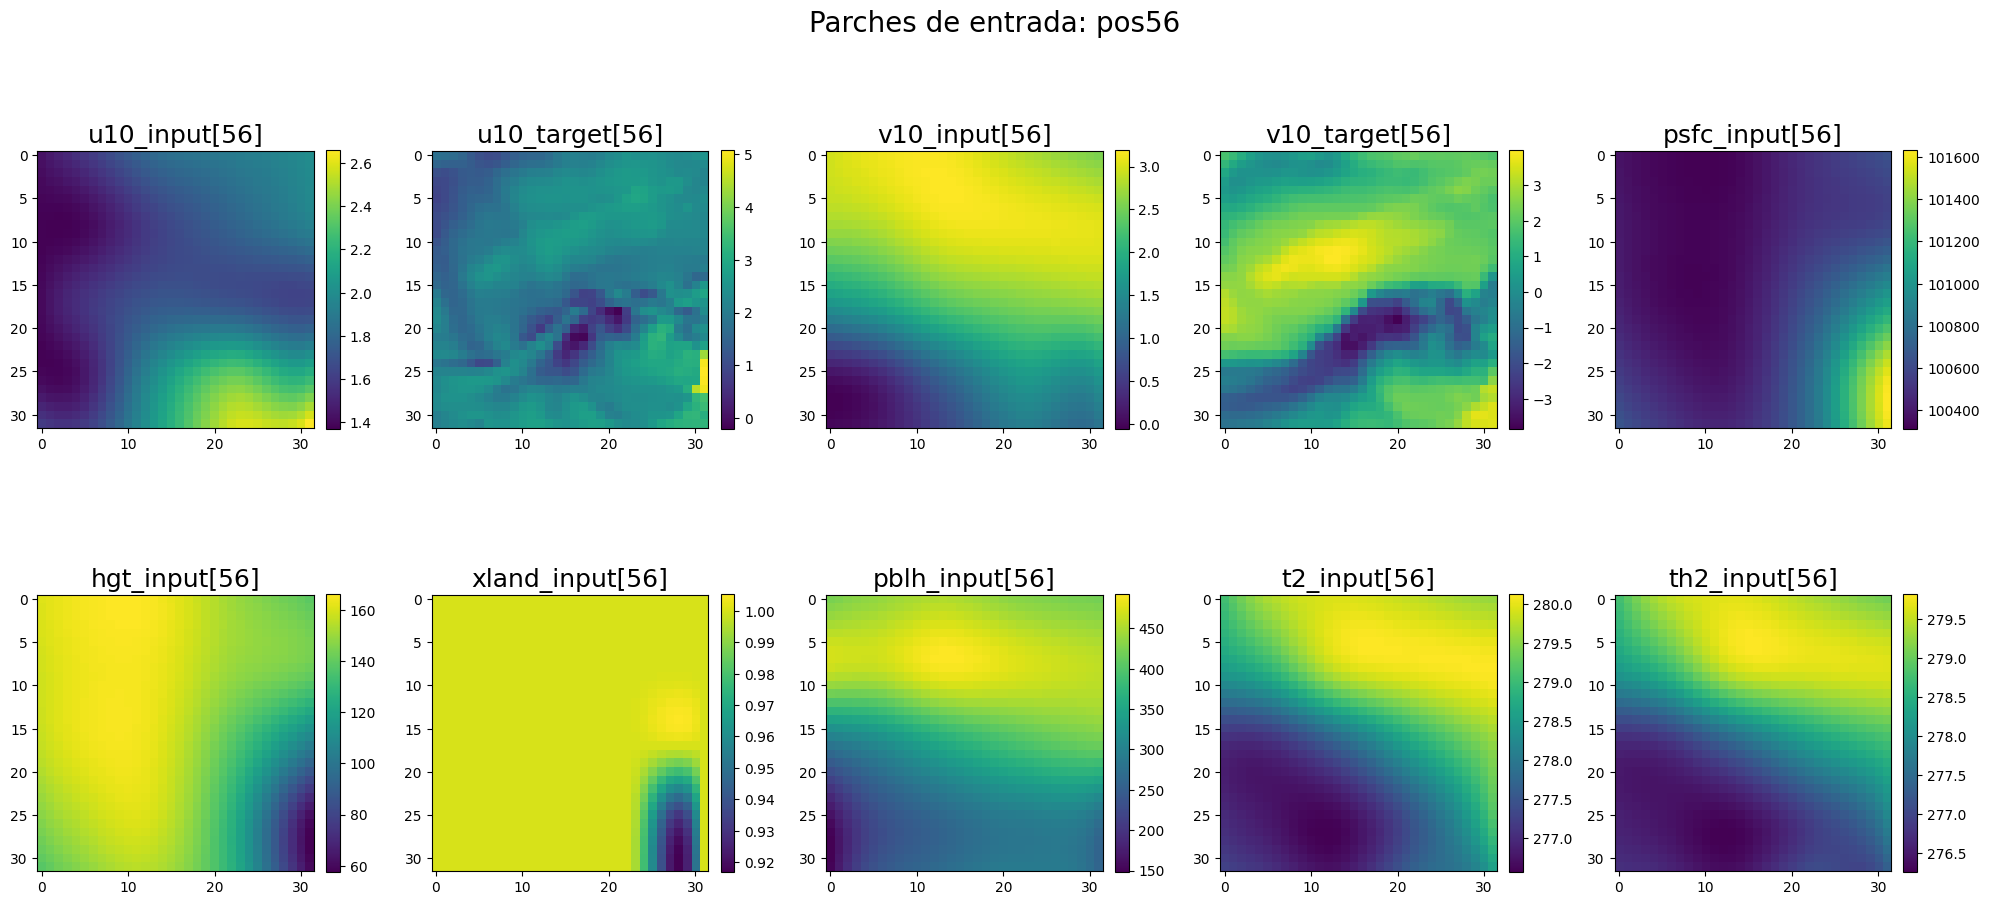

In [6]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np


idx=56
datos      =[ u10_input,   u10_target,   v10_input,   v10_target,   psfc_input,   hgt_input,   xland_input,   pblh_input,   t2_input,   th2_input ]
nombres_var=["u10_input", "u10_target", "v10_input", "v10_target", "psfc_input", "hgt_input", "xland_input", "pblh_input", "t2_input", "th2_input"]

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 5, figure=fig)
fig.suptitle(f'Parches de entrada: pos{idx}', fontsize=20)
axes = [fig.add_subplot(gs[0, i]) for i in range(5)]
axes += [fig.add_subplot(gs[1, i]) for i in range(5)]

for i, ax in enumerate(axes):
    im = ax.imshow(tf.squeeze(datos[i][idx]), cmap='viridis', vmin=tf.reduce_min(datos[i]), vmax=tf.reduce_max(datos[i]))
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, shrink=0.8)
    ax.set_title(f'{nombres_var[i]}[{idx}]', fontsize=18)
    im.set_clim( np.min(tf.squeeze(datos[i][idx])), np.max(tf.squeeze(datos[i][idx])))

plt.tight_layout() 
plt.show()

Debido a que la variable times está importada como un valor constante y no como parches de tamaño (32,32), lo que haremos es expandir el valor importado a las dimensiones de los parches requeridos y luego repetimos este nuevo parche una cantidad igual a los 156 parches asociados a cada registro temporal.

In [7]:
%%time

stack_time= tf.zeros([1, 32, 32, 1]) #inicializamos un stack con las dimensiones requeridas

for caso in fechas_tr:
    for i in range(115): 
        tiempo=  tf.fill([32, 32], stack["times"][caso][i].astype(np.float32) ) #llenamos un parche (32,32) con el registro temporal
        tiempo= tf.reshape(tiempo, [1, 32, 32, 1]) #expandimos a las nuevas dimensiones requeridas
        tiempo=  tf.repeat(tiempo, 156, axis=0) # repetivos 156 veces el parche temporal creado
        stack_time=tf.concat( [stack_time, tiempo], axis=0) #concatenamos los parches creados para cada registro temporal

time=stack_time[1:] #eliminamos el primer valor creado para inicializar el stack_time
print("Dimensiones tiempo: ",time.shape)

Dimensiones tiempo:  (287040, 32, 32, 1)
CPU times: total: 16min
Wall time: 2min 47s


#### Guardado de variables

Para efectos del guardado de variables, llamaremos ```bicubic_32_32``` a la carpeta que contendrá los arrays, "bicubic" se refiere a la interpolación utilizada y "32_32" a las dimensiones de los parches utilizados. Dentro de esta carpeta, los conjuntos de entrenamiento, validación y testeo tendrán su propia carpeta, por ejemplo, la carpeta del primer conjunto será ```190824_16_tr```, los primeros 6 dígitos hacen referencia a la fecha de cuando se crearon los datos, el segundo a la cantidad de casos utilizados y "tr" a la abreviación para "entrenamiento". Finalmente, debido a que cada variable input no ha sido normalizada (aún), añadiremos el sufijo "raw" haciendo alusión  a esta condición a cada ruta de guardado específica para cada variable. Eventualmente, cuando normalicemos estos datos, crearemos una carpeta llamada "norm" para el almacenamiento de estos nuevos datos. 

In [8]:
def guardado_parches(parches, nombre_parches, carpeta, opcional='', verbose=False):
    ruta_completa = os.path.join(carpeta, nombre_parches + opcional + '.npy')
    np.save(ruta_completa, parches)
    if verbose:
        print("Parches guardados exitosamente como: ", ruta_completa)

In [9]:
fecha= "190824_16_tr" #cambiar manualmente a va según corresponda
interp="bicubic_32_32/"
ruta_guardado="parches/" + interp +fecha+"/raw" #se recomienda sacar la carpeta

if not os.path.exists(ruta_guardado):
    
    os.makedirs(ruta_guardado)

    guardado_parches(u10_input,      "u10_input_raw_",     ruta_guardado, fecha)
    guardado_parches(u10_target,     "u10_target_raw_",    ruta_guardado, fecha)
    guardado_parches(v10_input,      "v10_input_raw_",     ruta_guardado, fecha)
    guardado_parches(v10_target,     "v10_target_raw_",    ruta_guardado, fecha)
    guardado_parches(hgt_input,      "hgt_input_raw_",    ruta_guardado, fecha)
    guardado_parches(xland_input,    "xland_input_raw_",   ruta_guardado, fecha)
    guardado_parches(pblh_input,     "pblh_input_raw_",    ruta_guardado, fecha)
    guardado_parches(psfc_input,     "psfc_input_raw_",    ruta_guardado, fecha)
    guardado_parches(th2_input,      "th2_input_raw_",     ruta_guardado, fecha)
    guardado_parches(t2_input,       "t2_input_raw_",     ruta_guardado, fecha)
    guardado_parches(time,           "time_raw_",          ruta_guardado, fecha)
                
    print("Parches guardados correctamente")
                
else:

    print("Ya existen variables guardadas en esa carpeta")

Parches guardados correctamente


#### Conjunto de validación 

In [10]:
from functions import extraccion_datos

stack=None
fechas_val=["2019_08_23", "2022_11_25", "2015_10_21", "2019_11_20", 
            "2019_11_06", "2020_11_13","2022_07_16", "2022_08_10"]

stack_va = extraccion_datos(var_names, fechas_val, path)

variable U10 lista
variable V10 lista
variable TH2 lista
variable PBLH lista
variable HGT lista
variable XLAND lista
variable T2 lista
variable PSFC lista
variable times lista


In [11]:
u10_input    =reshape_tensor(var="U10",  stack=stack_va, casos=fechas_val,input=True)
u10_target   =reshape_tensor(var="U10",  stack=stack_va, casos=fechas_val,input=False)
v10_input    =reshape_tensor(var="V10",  stack=stack_va, casos=fechas_val,input=True)
v10_target   =reshape_tensor(var="V10",  stack=stack_va, casos=fechas_val,input=False)
hgt_input    =reshape_tensor(var="HGT",  stack=stack_va, casos=fechas_val,input=True)
xland_input  =reshape_tensor(var="XLAND",stack=stack_va, casos=fechas_val,input=True)
pblh_input   =reshape_tensor(var="PBLH", stack=stack_va, casos=fechas_val,input=True)
th2_input    =reshape_tensor(var="TH2",  stack=stack_va, casos=fechas_val,input=True)
t2_input     =reshape_tensor(var="T2",   stack=stack_va, casos=fechas_val,input=True)
psfc_input   =reshape_tensor(var="PSFC", stack=stack_va, casos=fechas_val,input=True)

(143520, 32, 32, 1)
(143520, 32, 32, 1)
(143520, 32, 32, 1)
(143520, 32, 32, 1)
(143520, 32, 32, 1)
(143520, 32, 32, 1)
(143520, 32, 32, 1)
(143520, 32, 32, 1)
(143520, 32, 32, 1)
(143520, 32, 32, 1)


In [12]:
stack_time= tf.zeros([1, 32, 32, 1]) #inicializamos un stack con las dimensiones requeridas

for caso in fechas_val:
    for i in range(115): 
        tiempo=  tf.fill([32, 32], stack_va["times"][caso][i].astype(np.float32) ) 
        tiempo= tf.reshape(tiempo, [1, 32, 32, 1]) 
        tiempo=  tf.repeat(tiempo, 156, axis=0) 
        stack_time=tf.concat( [stack_time, tiempo], axis=0)

time=stack_time[1:] 
print("Dimensiones tiempo: ",time.shape)

Dimensiones tiempo:  (143520, 32, 32, 1)


In [13]:
fecha= "190824_16_va"
ruta_guardado="parches/" + interp +fecha+"/raw" #se recomienda sacar la carpeta

if not os.path.exists(ruta_guardado):
    
    os.makedirs(ruta_guardado)

    guardado_parches(u10_input,      "u10_input_raw_",     ruta_guardado, fecha)
    guardado_parches(u10_target,     "u10_target_raw_",    ruta_guardado, fecha)
    guardado_parches(v10_input,      "v10_input_raw_",     ruta_guardado, fecha)
    guardado_parches(v10_target,     "v10_target_raw_",    ruta_guardado, fecha)
    guardado_parches(hgt_input,      "hgt_input_raw_",     ruta_guardado, fecha)
    guardado_parches(xland_input,    "xland_input_raw_",   ruta_guardado, fecha)
    guardado_parches(pblh_input,     "pblh_input_raw_",    ruta_guardado, fecha)
    guardado_parches(psfc_input,     "psfc_input_raw_",    ruta_guardado, fecha)
    guardado_parches(th2_input,      "th2_input_raw_",     ruta_guardado, fecha)
    guardado_parches(t2_input,       "t2_input_raw_",      ruta_guardado, fecha)
    guardado_parches(time,           "time_raw_",          ruta_guardado, fecha)
                
    print("Parches guardados correctamente")
                
else:
    print("Ya existen variables guardadas en esa carpeta")

Parches guardados correctamente
